In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00


**Import Libraries**

In [2]:
import pandas as pd #v2.2.2
import numpy as np #v1.26.4
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor #v1.2.5
from lightgbm import LGBMRegressor
import joblib #v1.4.2
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**Load the Dataset**

In [3]:
# Load train and test data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

In [4]:
# Display the first few rows of the DataFrame
print(train_df.head())

   id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   Whole weight.2  Shell weight  Rings  
0          0.1465        0.2400     11  
1          0.2765        0.3200     11  
2          0.0030        0.0050      6  
3          0.2055        0.2500     10  
4          0.1600        0.1975      9  


In [ ]:
# Display the last few rows of the DataFrame
print(train_df.tail())

          id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
90610  90610   M   0.335     0.235   0.075        0.1585          0.0685   
90611  90611   M   0.555     0.425   0.150        0.8790          0.3865   
90612  90612   I   0.435     0.330   0.095        0.3215          0.1510   
90613  90613   I   0.345     0.270   0.075        0.2000          0.0980   
90614  90614   I   0.425     0.325   0.100        0.3455          0.1525   

       Whole weight.2  Shell weight  Rings  
90610          0.0370        0.0450      6  
90611          0.1815        0.2400      9  
90612          0.0785        0.0815      6  
90613          0.0490        0.0700      6  
90614          0.0785        0.1050      8  


In [5]:
# Display the shape of train and test datasets
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (90615, 10)
Test data shape: (60411, 9)


In [6]:
# Check for missing values
print("Missing values in each column:\n", train_df.isnull().sum())

Missing values in each column:
 id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64


In [7]:
# Check for duplicated values
num_duplicates = train_df.duplicated().sum()
print("Number of duplicated rows:", num_duplicates)

Number of duplicated rows: 0


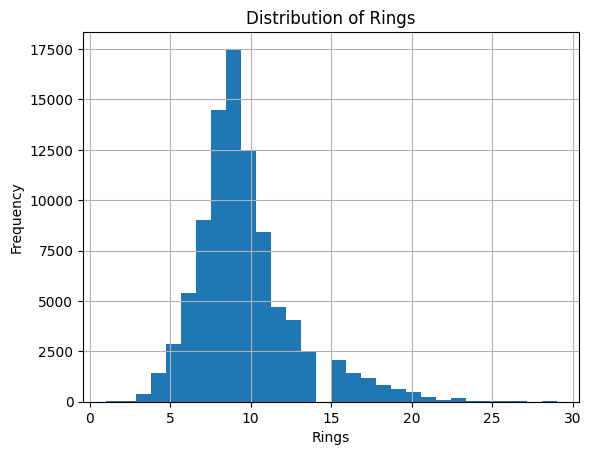

In [8]:
# Visualize the distribution of the target variable (Rings)
train_df['Rings'].hist(bins=30)
plt.title('Distribution of Rings')
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.show()

In [9]:
from collections import Counter

# Detect outliers using IQR
def detect_outliers(data, features, n=2):
    outliers = []

    for col in features:
        if data[col].dtype != 'object':
            Q1 = np.percentile(data[col], 25)
            Q3 = np.percentile(data[col], 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_list_col = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index
            outliers.extend(outlier_list_col)

    outliers = Counter(outliers)
    multiple_outliers = list(k for k, v in outliers.items() if v > n)
    return multiple_outliers


In [10]:
# Detect outlier in numerical features
outliers_to_drop = detect_outliers(train_df, train_df.columns.tolist(), n=2)
train_df_cleaned = train_df.drop(outliers_to_drop, axis=0).reset_index(drop=True)

print("Outliers to drop:", outliers_to_drop)
train_df = train_df.drop(outliers_to_drop, axis=0).reset_index(drop=True)

Outliers to drop: [2, 349, 800, 1207, 1420, 1524, 1531, 2079, 2082, 2097, 2127, 2285, 2571, 2651, 3247, 3351, 3387, 3845, 4069, 4257, 4753, 4758, 5052, 5105, 5490, 5652, 5702, 5851, 5960, 6035, 6092, 6210, 6340, 6364, 6700, 6716, 7285, 7349, 7542, 7572, 7683, 7827, 9270, 9621, 9764, 10482, 10568, 10796, 10846, 11031, 11133, 11245, 12007, 12722, 12852, 13044, 13071, 13183, 13260, 13617, 13621, 13630, 14037, 14458, 15613, 16146, 16374, 16434, 16620, 16661, 16954, 17031, 17262, 17453, 17774, 17785, 18039, 18131, 18489, 18812, 19302, 19542, 20060, 20449, 20575, 21407, 21458, 21531, 21581, 21999, 22203, 22443, 22552, 22741, 22846, 23041, 23702, 23748, 23767, 24202, 24530, 24535, 24585, 24592, 25099, 25356, 25631, 26375, 26478, 26653, 26701, 27339, 27446, 27512, 27851, 27871, 27962, 28521, 28577, 28669, 28777, 28784, 28922, 29057, 29246, 29269, 29944, 29956, 30025, 30274, 30609, 30667, 30705, 30876, 31124, 31268, 31392, 31791, 31879, 33079, 33149, 33823, 34383, 34412, 34529, 34610, 35447, 35

In [ ]:
# Show the result
print(f"Train data shape after dropping outliers: {train_df_cleaned.shape}")

Train data shape after dropping outliers: (89823, 10)


In [ ]:
# Summary statistics
summary_stats = train_df.describe()
print(summary_stats)

                 id        Length      Diameter        Height  Whole weight  \
count  89823.000000  89823.000000  89823.000000  89823.000000  89823.000000   
mean   45289.352883      0.517743      0.402177      0.135620      0.786352   
std    26154.017785      0.115627      0.096026      0.037215      0.447128   
min        0.000000      0.075000      0.060000      0.000000      0.005000   
25%    22646.500000      0.450000      0.345000      0.110000      0.421500   
50%    45270.000000      0.545000      0.425000      0.140000      0.799500   
75%    67935.500000      0.600000      0.470000      0.160000      1.065000   
max    90614.000000      0.815000      0.650000      1.130000      2.779500   

       Whole weight.1  Whole weight.2  Shell weight         Rings  
count    89823.000000    89823.000000  89823.000000  89823.000000  
mean         0.339358        0.168865      0.225244      9.708738  
std          0.199088        0.098756      0.127400      3.149387  
min          0.0

In [ ]:
# Check column names
print(train_df.columns)

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')


In [ ]:
# Summary of dataset in tableview
train_df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,89823.000000,89823.000000,89823.000000,89823.000000,89823.000000,89823.000000,89823.000000,89823.000000,89823.000000
mean,45289.352883,0.517743,0.402177,0.135620,0.786352,0.339358,0.168865,0.225244,9.708738
std,26154.017785,0.115627,0.096026,0.037215,0.447128,0.199088,0.098756,0.127400,3.149387
min,0.000000,0.075000,0.060000,0.000000,0.005000,0.002000,0.000500,0.001500,1.000000
25%,22646.500000,0.450000,0.345000,0.110000,0.421500,0.178500,0.087500,0.120000,8.000000
50%,45270.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67935.500000,0.600000,0.470000,0.160000,1.065000,0.462500,0.231500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.779500,1.351000,0.760000,1.005000,29.000000


Text(0.5, 1.0, 'Count plot of Sex')

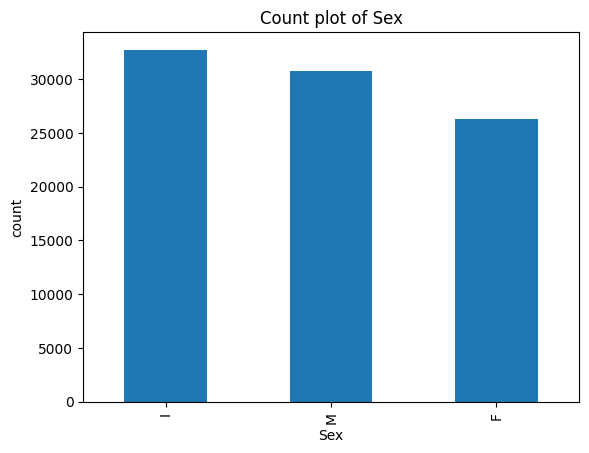

In [ ]:
# Visualize bar plot
plt = train_df['Sex'].value_counts().plot(kind='bar')
plt.set_xlabel('Sex')
plt.set_ylabel('count')
plt.set_title('Count plot of Sex')

Text(0.5, 1.0, 'Count plot of Rings')

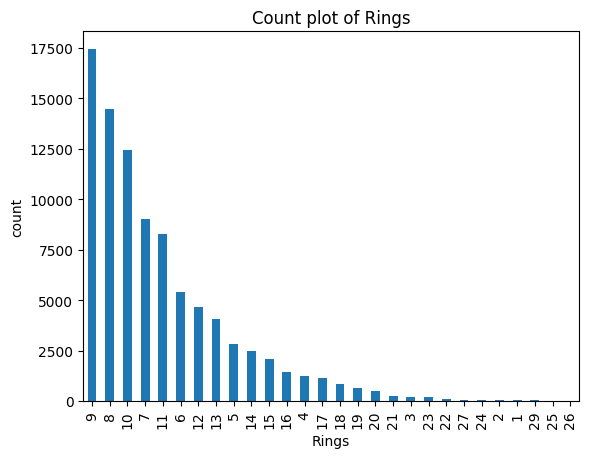

In [ ]:
# Visualize the Rings plot
plt = train_df['Rings'].value_counts().plot(kind='bar')
plt.set_xlabel('Rings')
plt.set_ylabel('count')
plt.set_title('Count plot of Rings')

In [ ]:
import matplotlib.pyplot as plt  # Import the pyplot module
import seaborn as sns

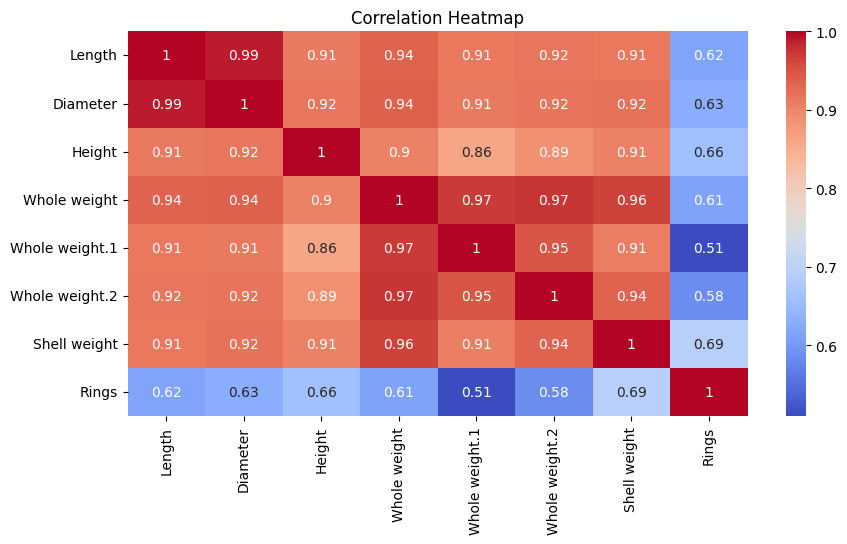

In [ ]:
# Visualize the corellation matrix using heatmap
plt.figure(figsize=(10, 5))  # Create a figure
corr = train_df.drop(columns = ['id', 'Sex']).corr()
sns.heatmap(corr, annot=True, cbar=True, cmap='coolwarm')
plt.title('Correlation Heatmap') # Now plt refers to the correct module
plt.show()

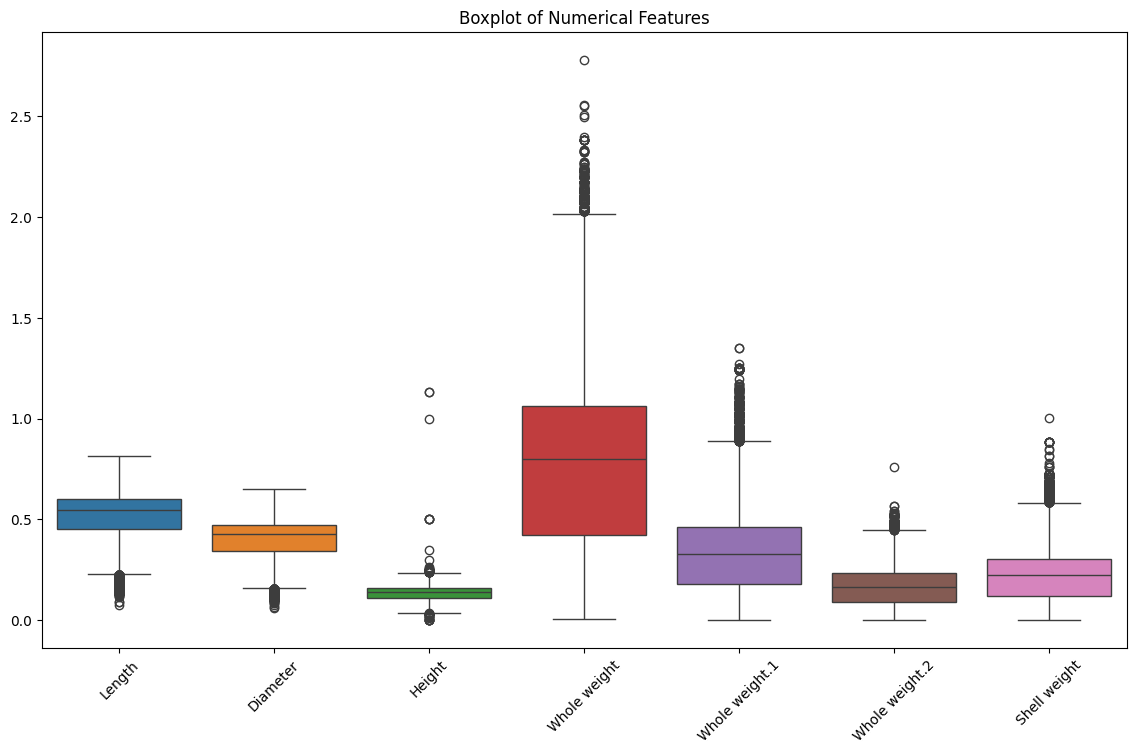

In [ ]:
# Plot the boxplot for all numerical features in the training dataset
plt.figure(figsize=(14, 8))
sns.boxplot(data=train_df.drop(columns=['id', 'Rings']))  # Exclude the 'id' and 'Rings' columns
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.show()

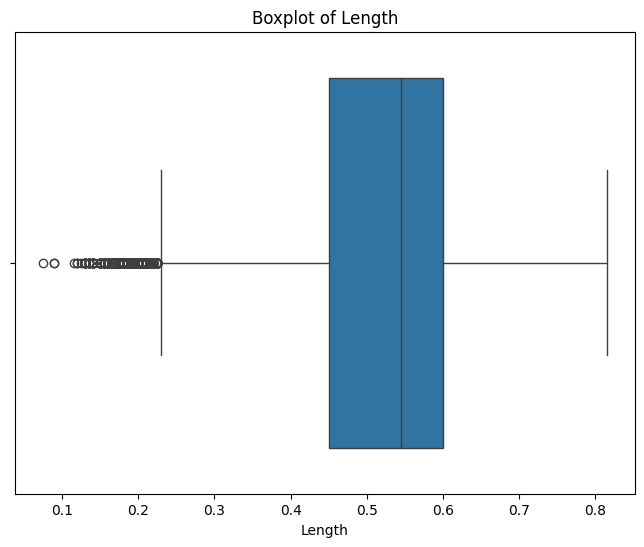

In [ ]:
# Boxplot for a specific feature, e.g., 'Length'
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_df['Length'])
plt.title('Boxplot of Length')
plt.show()


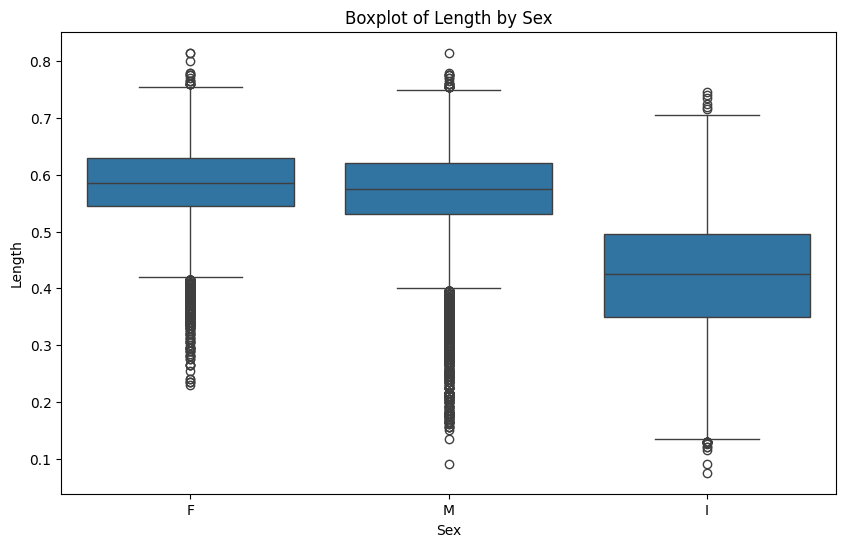

In [ ]:
# Boxplot grouped by 'Sex'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='Length', data=train_df)
plt.title('Boxplot of Length by Sex')
plt.show()


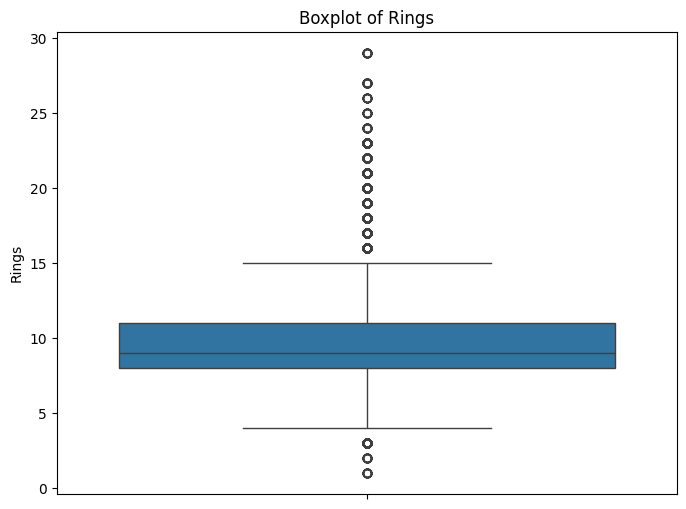

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_df['Rings'])
plt.title('Boxplot of Rings')
plt.show()


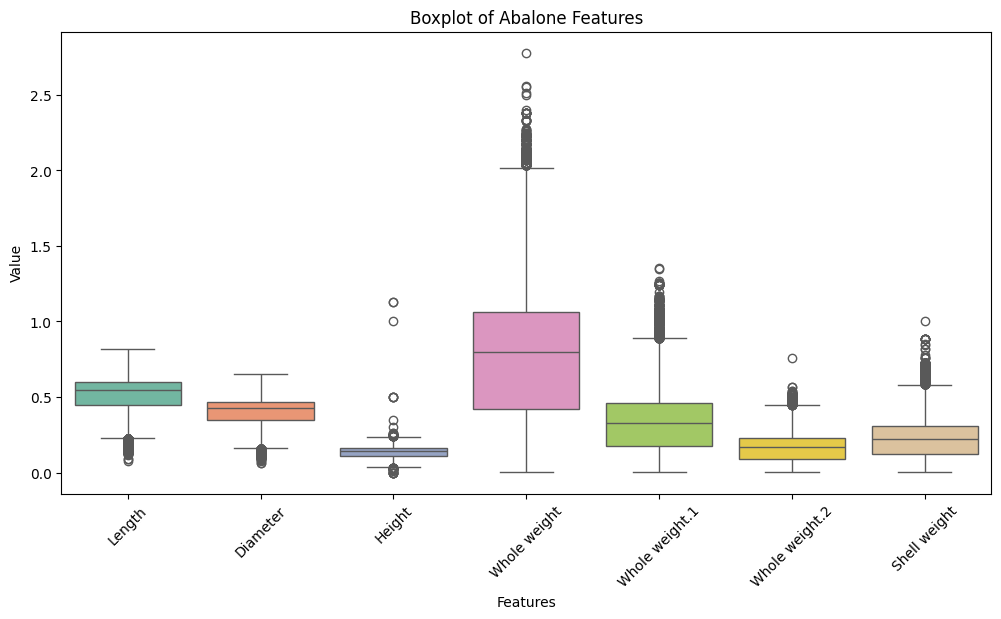

In [ ]:
# Customizing the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df.drop(columns=['id', 'Rings']), palette="Set2")
plt.title('Boxplot of Abalone Features')
plt.xlabel('Features')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


<Figure size 1000x600 with 0 Axes>

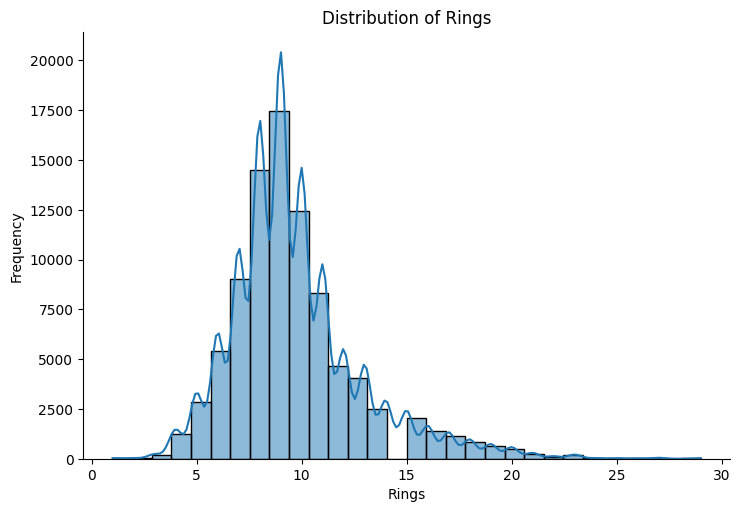

In [ ]:
# Draw the displot for the 'Rings' column
plt.figure(figsize=(10, 6))
sns.displot(train_df['Rings'], kde=True, bins=30, aspect=1.5)
plt.title('Distribution of Rings')
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.show()

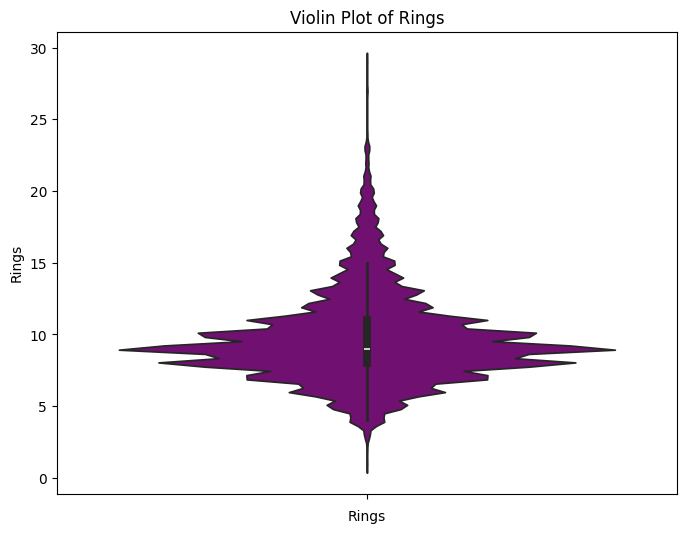

In [ ]:
# Draw a violin plot for the 'Rings' column
plt.figure(figsize=(8, 6))
sns.violinplot(y=train_df['Rings'], color='purple')
plt.title('Violin Plot of Rings')
plt.xlabel('Rings')
plt.show()

**Model Model Evaluation - Model Selection & trainng**

In [11]:
# Encode categorical variables
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])

In [12]:
# Split data into features and target variable
X = train_df.drop(['id', 'Rings'], axis=1)
y = train_df['Rings']
X_test = test_df.drop('id', axis=1)

In [13]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Define custom RMSLE scorer
def rmsle_score(y_true, y_pred):
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))
    return rmsle

rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

Deifine Models

In [15]:
# # Define models with hyperparameters
# models = {
#     'LinearRegression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
# }

**Main**

In [ ]:
# # Define models with hyperparameters
# models = {
#     'LinearRegression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
#     'DecisionTreeRegressor': {
#         'model': DecisionTreeRegressor(random_state=42),
#         'params': {
#             'max_depth': [5, 10, 15, None],
#             'min_samples_split': [2, 5, 10]
#         }
#     },
#     'RandomForestRegressor': {
#         'model': RandomForestRegressor(random_state=42),
#         'params': {
#             'n_estimators': [100, 200],
#             'max_depth': [10, 15, None],
#             'min_samples_split': [2, 5, 10]
#         }
#     },
#     'GradientBoostingRegressor': {
#         'model': GradientBoostingRegressor(random_state=42),
#         'params': {
#             'n_estimators': [100, 200],
#             'learning_rate': [0.01, 0.1, 0.2],
#             'max_depth': [3, 5, 10]
#         }
#     },
#     'SVR': {
#         'model': SVR(),
#         'params': {
#             'C': [0.1, 1],
#             'kernel': ['linear']
#         }
#     },
#     'XGBRegressor': {
#         'model': XGBRegressor(random_state=42),
#         'params': {
#             'n_estimators': [100, 200],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [3, 5, 10]
#         }
#     },
#     'CatBoostRegressor': {
#         'model': CatBoostRegressor(verbose=0, random_state=42),
#         'params': {
#             'iterations': [100, 200],
#             'depth': [4, 6, 10],
#             'learning_rate': [0.01, 0.1]
#         }
#     },
#     'LGBMRegressor': {
#         'model': LGBMRegressor(random_state=42),
#         'params': {
#             'n_estimators': [100, 200],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [5, 10, 15]
#         }
#     }
# }


**v5**

In [ ]:
# # Define models with hyperparameters
# models = {
#     'LinearRegression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
#     'DecisionTreeRegressor': {
#         'model': DecisionTreeRegressor(random_state=42),
#         'params': {
#             'max_depth': [3, 5, 10],
#             'min_samples_split': [2, 5, 10]
#         }
#     },
#     'RandomForestRegressor': {
#         'model': RandomForestRegressor(random_state=42),
#         'params': {
#             'n_estimators': [20, 50],
#             'max_depth': [3, 5, 10],
#             'min_samples_split': [2, 5, 10]
#         }
#     },
#     'GradientBoostingRegressor': {
#         'model': GradientBoostingRegressor(random_state=42),
#         'params': {
#             'n_estimators': [20, 50],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [3, 5, 10]
#         }
#     },
#     'SVR': {
#         'model': SVR(),
#         'params': {
#             'C': [0.1, 1],
#             'kernel': ['linear']
#         }
#     },
#     'XGBRegressor': {
#         'model': XGBRegressor(random_state=42),
#         'params': {
#             'n_estimators': [20, 50],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [3, 5, 10]
#         }
#     },
#     'CatBoostRegressor': {
#         'model': CatBoostRegressor(verbose=0, random_state=42),
#         'params': {
#             'iterations': [20, 50],
#             'depth': [3, 5, 10],
#             'learning_rate': [0.01, 0.1]
#         }
#     },
#     'LGBMRegressor': {
#         'model': LGBMRegressor(random_state=42),
#         'params': {
#             'n_estimators': [20, 50],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [3, 5, 10]
#         }
#     }
# }


V6

In [ ]:
# # Define models with hyperparameters
# models = {
#     'LinearRegression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
#     'DecisionTreeRegressor': {
#         'model': DecisionTreeRegressor(random_state=42),
#         'params': {
#             'max_depth': [3, 5, 15],
#             'min_samples_split': [2, 5, 12]
#         }
#     },
#     'RandomForestRegressor': {
#         'model': RandomForestRegressor(random_state=42),
#         'params': {
#             'n_estimators': [50, 100],
#             'max_depth': [3, 5, 12],
#             'min_samples_split': [2, 5, 15]
#         }
#     },
#     'GradientBoostingRegressor': {
#         'model': GradientBoostingRegressor(random_state=42),
#         'params': {
#             'n_estimators': [50, 100],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [5, 10, 15]
#         }
#     },
#     'SVR': {
#         'model': SVR(),
#         'params': {
#             'C': [0.01, 0.1],
#             'kernel': ['linear']
#         }
#     },
#     'XGBRegressor': {
#         'model': XGBRegressor(random_state=42),
#         'params': {
#             'n_estimators': [50, 100],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [5, 10, 15]
#         }
#     },
#     'CatBoostRegressor': {
#         'model': CatBoostRegressor(verbose=0, random_state=42),
#         'params': {
#             'iterations': [50, 100],
#             'depth': [5, 10, 15],
#             'learning_rate': [0.01, 0.1]
#         }
#     },
#     'LGBMRegressor': {
#         'model': LGBMRegressor(random_state=42),
#         'params': {
#             'n_estimators': [50, 100],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [5, 10, 15]
#         }
#     }
# }


**V7**

In [ ]:
# # Define models with hyperparameters
# models = {
#     'LinearRegression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
#     'DecisionTreeRegressor': {
#         'model': DecisionTreeRegressor(random_state=42),
#         'params': {
#             'max_depth': [3, 5, 12],
#             'min_samples_split': [2, 5, 12]
#         }
#     },
#     'RandomForestRegressor': {
#         'model': RandomForestRegressor(random_state=42),
#         'params': {
#             'n_estimators': [30, 90],
#             'max_depth': [3, 5, 12],
#             'min_samples_split': [2, 5, 12]
#         }
#     },
#     'GradientBoostingRegressor': {
#         'model': GradientBoostingRegressor(random_state=42),
#         'params': {
#             'n_estimators': [30, 90],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [3, 5, 12]
#         }
#     },
#     'SVR': {
#         'model': SVR(),
#         'params': {
#             'C': [0.01, 0.1],
#             'kernel': ['linear']
#         }
#     },
#     'XGBRegressor': {
#         'model': XGBRegressor(random_state=42),
#         'params': {
#             'n_estimators': [30, 90],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [3, 5, 12]
#         }
#     },
#     'CatBoostRegressor': {
#         'model': CatBoostRegressor(verbose=0, random_state=42),
#         'params': {
#             'iterations': [30, 90],
#             'depth': [3, 5, 12],
#             'learning_rate': [0.01, 0.1]
#         }
#     },
#     'LGBMRegressor': {
#         'model': LGBMRegressor(random_state=42),
#         'params': {
#             'n_estimators': [30, 90],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [3, 5, 12]
#         }
#     }
# }


**v13 - Best Model**

In [15]:
# Define models with hyperparameters
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [5, 10, 15],
            'min_samples_split': [5, 10, 15]
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, 15],
            'min_samples_split': [5, 10, 15]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [5, 10, 15]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.01, 0.1],
            'kernel': ['linear']
        }
    },
    'XGBRegressor': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [5, 10, 15]
        }
    },
    'CatBoostRegressor': {
        'model': CatBoostRegressor(verbose=0, random_state=42),
        'params': {
            'iterations': [100, 200],
            'depth': [5, 10, 15],
            'learning_rate': [0.01, 0.1]
        }
    },
    'LGBMRegressor': {
        'model': LGBMRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [5, 10, 15]
        }
    }
}


In [16]:
# Track best model and its RMSLE score
best_model = None
best_model_name = ""
best_rmsle = float('inf')

# Evaluate models
for name, model_data in models.items():
    grid_search = GridSearchCV(estimator=model_data['model'], param_grid=model_data['params'],
                               cv=5, scoring=rmsle_scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Predictions
    y_pred = grid_search.best_estimator_.predict(X_val)

    # Calculate RMSLE score
    rmsle = rmsle_score(y_val, y_pred)

    # Print RMSLE score and best params
    print(f"{name}: RMSLE: {rmsle:.4f}")
    print(f"Best Params: {grid_search.best_params_}")

    # Update best model if current model has lower RMSLE
    if rmsle < best_rmsle:
        best_model = grid_search.best_estimator_
        best_model_name = name
        best_rmsle = rmsle

# Print name of the best model
print(f"Best model: {best_model_name} with RMSLE: {best_rmsle:.4f}")

LinearRegression: RMSLE: 0.1664
Best Params: {}
DecisionTreeRegressor: RMSLE: 0.1571
Best Params: {'max_depth': 10, 'min_samples_split': 15}
RandomForestRegressor: RMSLE: 0.1492
Best Params: {'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 200}
GradientBoostingRegressor: RMSLE: 0.1487
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
SVR: RMSLE: 0.1670
Best Params: {'C': 0.1, 'kernel': 'linear'}


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBRegressor: RMSLE: 0.1488
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CatBoostRegressor: RMSLE: 0.1490
Best Params: {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 71858, number of used features: 8
[LightGBM] [Info] Start training from score 9.713838
LGBMRegressor: RMSLE: 0.1484
Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best model: LGBMRegressor with RMSLE: 0.1484


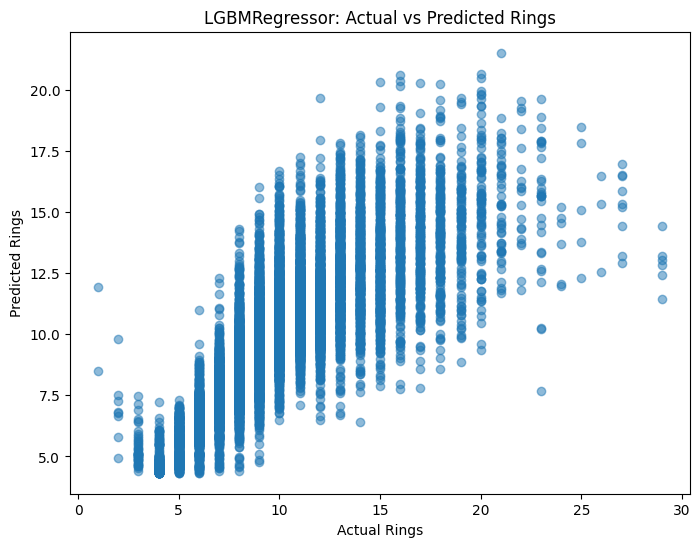

In [17]:
# Scatter plot of actual vs predicted values for the best model
plt.figure(figsize=(8, 6))
plt.scatter(y_val, best_model.predict(X_val), alpha=0.5)
plt.title(f'{best_model_name}: Actual vs Predicted Rings')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.show()

In [18]:
# Train the best performing model on full data
best_model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 89823, number of used features: 8
[LightGBM] [Info] Start training from score 9.708738


LGBMRegressor(max_depth=10, n_estimators=200, random_state=42)

In [19]:
# Save the best model using joblib
joblib.dump(best_model, 'best_model_V13')

['best_model_V13']

In [20]:
# Prediction on the test set
predictions = best_model.predict(X_test)

In [21]:
# Prepare submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'Rings': predictions})
submission_df.to_csv('submission.csv', index=False)

In [22]:
# Display column names
print("Columns in the training data:", train_df.columns)

Columns in the training data: Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')


In [23]:
# Single prediction using the best model
# Load the saved model
best_model = joblib.load('best_model_V13')

In [28]:
# Prepare a dataframe with the features for prediction
# Example Data
data = {'Sex': ['Male'],
        'Length': [0.58],
        'Diameter': [0.46],
        'Height': [0.16],
        'Whole weight': [0.983],
        'Whole weight.1': [0.4785],
        'Whole weight.2': [0.2195],
        'Shell weight': [0.275]}
predict_df = pd.DataFrame(data)

In [29]:
# Encode categorical variables
le.fit(['Male', 'Female', 'Infant'])
predict_df['Sex'] = le.transform(predict_df['Sex'])

In [30]:
# Make prediction
prediction = best_model.predict(predict_df)

In [31]:
print("Predicted Rings:", prediction)

Predicted Rings: [9.62174259]
